In [1]:
import os
os.chdir('..')

In [2]:
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
from src.utils.dataset import ms_data
from src.utils.utils import split_train_test

In [7]:
intensities_file = 'data/canis_intensities.csv'
dataset_name = intensities_file.split('/')[-1].split('_')[0]
data, labels, samples = ms_data(intensities_file)
data[np.isnan(data)] = 0

for i, label in enumerate(labels):
    if label != 'Normal':
        labels[i] = 'Not Normal'
        
categories = pd.Categorical(labels).codes
samples_df = pd.concat([
    pd.DataFrame(np.array(samples).reshape([-1, 1])),
    pd.DataFrame(np.array(categories).reshape([-1, 1])),
    pd.DataFrame(np.array(labels).reshape([-1, 1])),
], 1)
samples_df.columns = ['sample', 'category', 'label']


In [8]:
samples_df

,sample,category,label
0,1,1,Not Normal
1,1,1,Not Normal
2,1,1,Not Normal
3,1,1,Not Normal
4,1,1,Not Normal
...,...,...,...
2223,9,1,Not Normal
2224,9,1,Not Normal
2225,9,1,Not Normal
2226,9,1,Not Normal


In [6]:
train_samples, test_samples, train_cats = split_train_test(samples_df)
train_indices = [s for s, lab in enumerate(samples_df['sample']) if lab in train_samples]
test_indices = [s for s, lab in enumerate(samples_df['sample']) if lab in test_samples]

train_data = data[train_indices]
test_data = data[test_indices]
train_labels = samples_df['category'][train_indices].tolist()
test_labels = samples_df['category'][test_indices].tolist()


In [7]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(train_data, train_labels)
test_pcs = pca.transform(test_data)
principal_df = pd.DataFrame(data=principal_components, 
                            columns=['principal component 1', 'principal component 2'])
test_principal_df = pd.DataFrame(data=test_pcs, 
                                 columns=['principal component 1', 'principal component 2'])
labels_df = pd.DataFrame(train_labels)
labels_df.index = principal_df.index
final_df = pd.DataFrame(np.concatenate((principal_df.values, labels_df.values), axis=1),
                        columns=list(principal_df.columns) + ['label'])

test_labels_df = pd.DataFrame(test_labels)
test_labels_df.index = test_principal_df.index
test_final_df = pd.DataFrame(np.concatenate((test_principal_df.values, test_labels_df.values), axis=1),
                             columns=list(test_principal_df.columns) + ['label'])


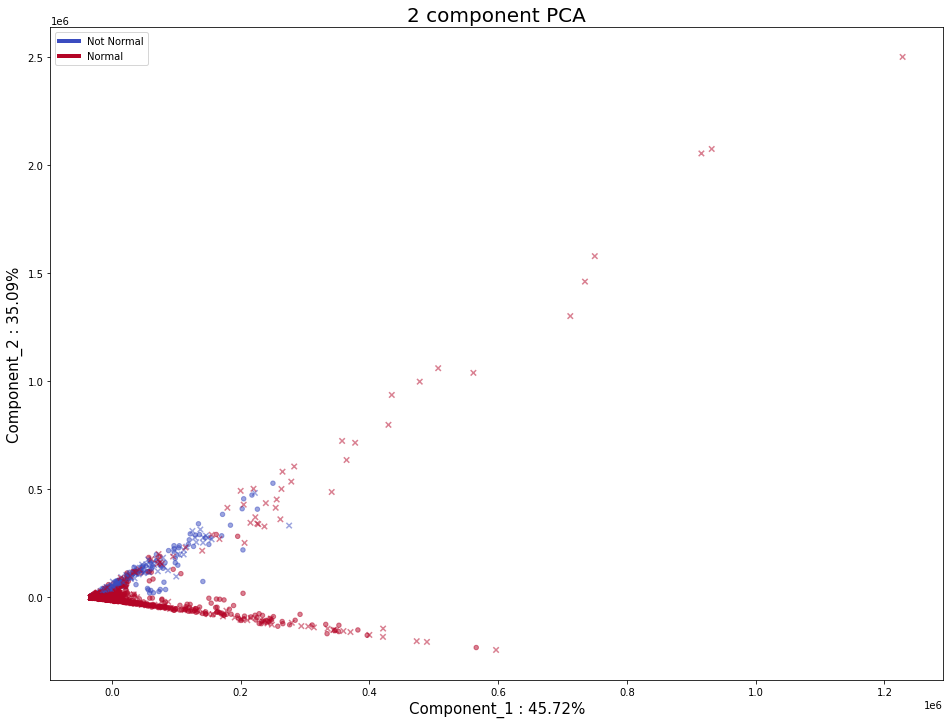

In [9]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ev = pca.explained_variance_ratio_
pc1 = 'Component_1 : ' + str(np.round(ev[0] * 100, decimals=2)) + "%"
pc2 = 'Component_2 : ' + str(np.round(ev[1] * 100, decimals=2)) + "%"
ax.set_xlabel(pc1, fontsize=15)
ax.set_ylabel(pc2, fontsize=15)
ax.set_title('2 component PCA', fontsize=20)
cmap = plt.cm.coolwarm

num_targets = len(set(train_labels))

cols = cmap(np.linspace(0, 1, num_targets))
colors = rcParams['axes.prop_cycle'] = cycler(color=cols)

colors_list = []
data1_list = []
data2_list = []
for t, target in enumerate(list(set(train_labels))):
    indices_to_keep = [True if x == target else False for x in list(final_df.label)]
    data1 = list(final_df.loc[indices_to_keep, 'principal component 1'])
    data2 = list(final_df.loc[indices_to_keep, 'principal component 2'])

    data1_list += [data1]
    data2_list += [data2]
    colors_list += [np.array([[cols[t]] * len(data1)])]

colors_vector = np.hstack(colors_list).squeeze()
data1_vector = np.hstack(data1_list).reshape(-1, 1)
data2_vector = np.hstack(data2_list).reshape(-1, 1)
data_colors_vector = np.concatenate((data1_vector, data2_vector, colors_vector), axis=1)
data1 = data_colors_vector[:, 0]
data2 = data_colors_vector[:, 1]
col = data_colors_vector[:, 2:]

ax.scatter(data1, data2, s=20, alpha=0.5, c=col, label=train_labels)
custom_lines = [Line2D([0], [0], color=cols[x], lw=4) for x in range(num_targets)]

colors_list = []
data1_list = []
data2_list = []
for t, target in enumerate(list(set(test_labels))):
    indices_to_keep = [True if x == target else False for x in list(test_final_df.label)]
    data1 = list(test_final_df.loc[indices_to_keep, 'principal component 1'])
    data2 = list(test_final_df.loc[indices_to_keep, 'principal component 2'])

    data1_list += [data1]
    data2_list += [data2]
    colors_list += [np.array([[cols[t]] * len(data1)])]

colors_vector = np.hstack(colors_list).squeeze()
data1_vector = np.hstack(data1_list).reshape(-1, 1)
data2_vector = np.hstack(data2_list).reshape(-1, 1)
data_colors_vector = np.concatenate((data1_vector, data2_vector, colors_vector), axis=1)
data1 = data_colors_vector[:, 0]
data2 = data_colors_vector[:, 1]
col = data_colors_vector[:, 2:]

ax.scatter(data1, data2, s=30, alpha=0.5, c=col, label=test_labels, marker='x')

custom_lines += [Line2D([0], [0], color=cols[x], lw=4) for x in range(num_targets)]

ax.legend(custom_lines, list(set(samples_df['label'])))

plt.show()
plt.close()
